# Himmelblau function

Illustrations of a parameter estimation method `scipy.optimize.minimize`) and ensemble method `emcee` applied to finding the minimum of the Himmelblau function. 
https://en.wikipedia.org/wiki/Himmelblau%27s_function

$(x62 + x - 11)^2 + (x + y^2 - 7)^2$

## Parameter estimation


--- Optimizing from initial point: [0. 0.] ---
Optimization result for initial point [0. 0.]:
          message: `gtol` termination condition is satisfied.
          success: True
           status: 1
              fun: 5.007586609241633e-20
                x: [ 3.000e+00  2.000e+00]
              nit: 13
             nfev: 13
             njev: 11
             nhev: 11
         cg_niter: 15
     cg_stop_cond: 4
             grad: [ 5.921e-10 -1.492e-09]
  lagrangian_grad: [ 5.921e-10 -1.492e-09]
           constr: []
              jac: []
      constr_nfev: []
      constr_njev: []
      constr_nhev: []
                v: []
           method: equality_constrained_sqp
       optimality: 1.4917524992572883e-09
 constr_violation: 0
   execution_time: 0.01597309112548828
        tr_radius: 4.304090553539614
   constr_penalty: 1.0
            niter: 13

--- Optimizing from initial point: [ 0. -5.] ---
Optimization result for initial point [ 0. -5.]:
          message: `gtol` termination 

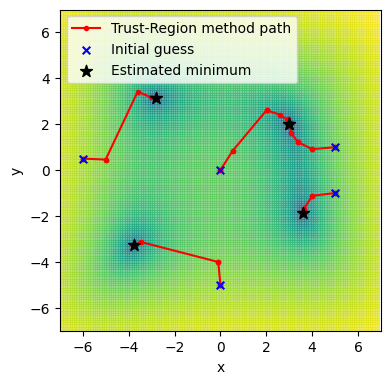

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.optimize import minimize

def modified_himmelblau(x):
    return (x[0]**2 + x[1] - 11)**2 + (x[0] + x[1]**2 - 7)**2

def modified_himmelblau_grad(x):
    df_dx = 4 * x[0] * (x[0]**2 + x[1] - 11) + 2 * (x[0] + x[1]**2 - 7)
    df_dy = 2 * (x[0]**2 + x[1] - 11) + 4 * x[1] * (x[0] + x[1]**2 - 7)
    return np.array([df_dx, df_dy])

def modified_himmelblau_hess(x):
    h11 = 12 * x[0]**2 + 4 * x[1] - 42
    h12 = 4 * x[0] + 4 * x[1]
    h21 = 4 * x[0] + 4 * x[1]
    h22 = 4 * x[0] + 12 * x[1]**2 - 26
    return np.array([[h11, h12], [h21, h22]])

# Define multiple initial guesses
initial_points = [
    np.array([0.0, 0.0]),   # First starting point
    np.array([0.0, -5.0]), # Second starting point
    np.array([5.0, -1.0]),    # Third starting point
    np.array([5.0, 1.0]),    # Fourht starting point
        np.array([-6.0, 0.5])    # Fourht starting point
]

# Lists to store the path and initial point for each optimization run
all_paths = []
all_initial_points = []
all_results_x = [] # To store the final converged x,y for plotting

# Run optimization for each initial point
for i, current_initial_point in enumerate(initial_points):
    # Store the path taken by the optimizer using a callback
    current_path = [current_initial_point.copy()]
    def callback(xk, state, current_path=current_path): # Using closure for callback
        current_path.append(xk.copy())

    print(f"\n--- Optimizing from initial point: {current_initial_point} ---")
    result = minimize(modified_himmelblau, current_initial_point, method='trust-constr',
                      jac=modified_himmelblau_grad, hess=modified_himmelblau_hess,
                      callback=callback)

    print(f"Optimization result for initial point {current_initial_point}:\n{result}")

    all_paths.append(np.array(current_path))
    all_initial_points.append(current_initial_point)
    all_results_x.append(result.x) # Store the final optimized point

# --- Plotting ---
fig = plt.figure(figsize=(4, 4)) # Keeping original figure size
ax = fig.gca()

X = np.arange(-7, 7, 0.1)
Y = np.arange(-7, 7, 0.1)
X, Y = np.meshgrid(X, Y)
Z = modified_himmelblau([X,Y])
im = ax.pcolor(X,Y,Z, norm=colors.LogNorm(vmin=10**-2, vmax=Z.max()), cmap='viridis', alpha=0.7)

# Plot each optimization path with the same color ('r') and symbol ('-o')
for i, path in enumerate(all_paths):
    # Only the first path gets a label for the legend
    label_path = 'Trust-Region method path' if i == 0 else None
    ax.plot(path[:, 0], path[:, 1], 'r-o', markersize=3, label=label_path)

    # Plot initial point using the same color ('blue') and marker ('x') for all
    label_initial = 'Initial guess' if i == 0 else None
    ax.scatter(all_initial_points[i][0], all_initial_points[i][1],
               color='blue', marker='x', s=30, label=label_initial, zorder=10)

    # Plot the found minimum for each path using the same color ('black') and marker ('*')
    label_found_min = 'Estimated minimum' if i == 0 else None
    ax.scatter(all_results_x[i][0], all_results_x[i][1],
               color='black', marker='*', s=80, label=label_found_min, zorder=10)

# Removed the line for plotting the fixed "True Global Minimum"

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim([-7, 7])
ax.set_ylim([-7, 7])
ax.set_aspect('equal', adjustable='box')

# Place legend outside the plot for better readability
ax.legend(loc='upper left')
plt.tight_layout() # Adjust layout to prevent labels/legend from overlapping

plt.savefig("parameter_estimation.png")
plt.show()

## Ensemble method

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 3074.04it/s]


Autocorrelation times: [52.46114943 83.90328263]
Maximum estimated autocorrelation time: 84
Number of samples after thinning: 2143


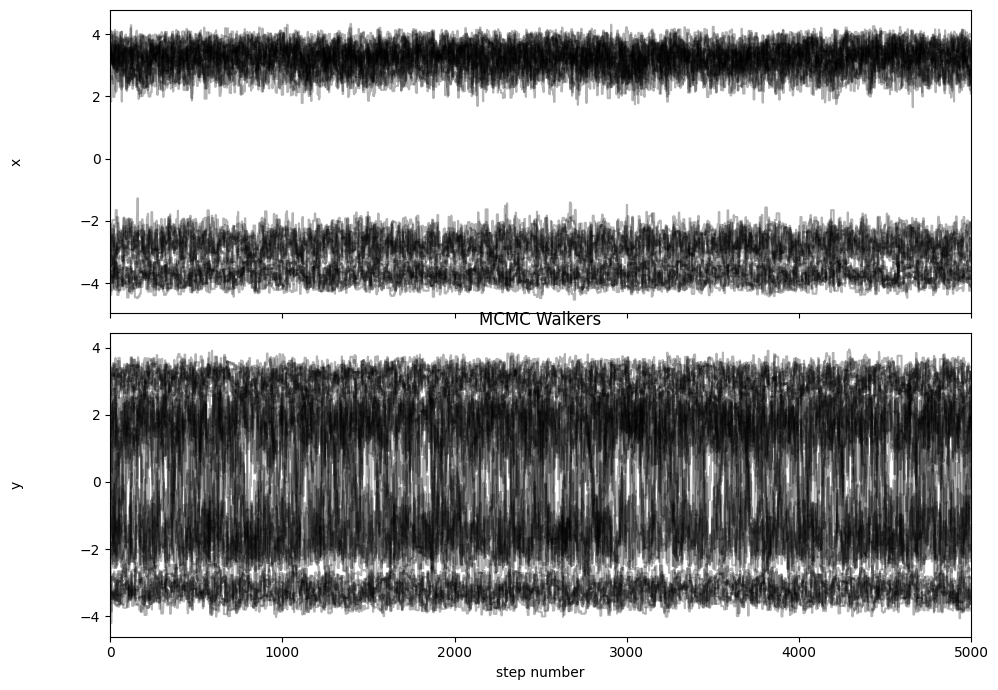

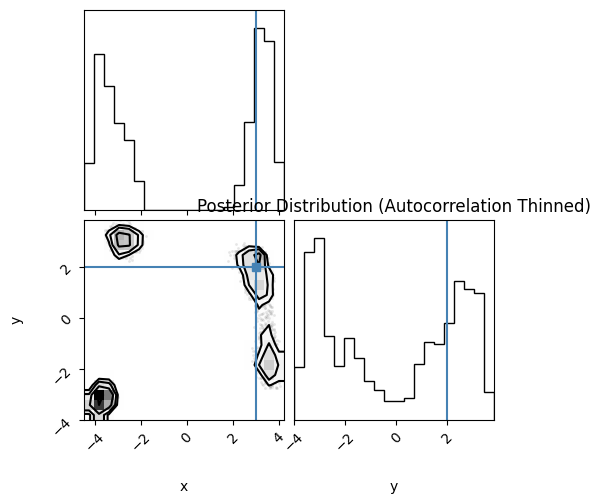

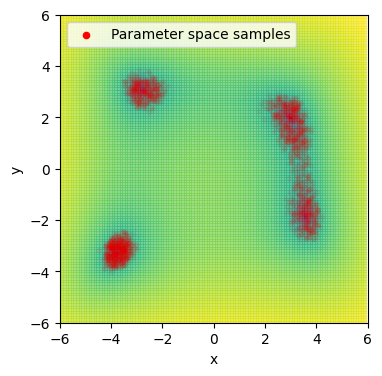

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner

# Define the modified Himmelblau function (as before)
def modified_himmelblau(x):
    return (x[0]**2 + x[1] - 11)**2 + (x[0] + x[1]**2 - 7)**2

# Define the log-likelihood and log-prior (as before)
def log_likelihood(theta, data):
    x, y = theta
    value = modified_himmelblau([x, y])
    sigma = data
    return -0.5 * (value / sigma)**2

def log_prior(theta):
    x, y = theta
    if -6.0 < x < 6.0 and -6.0 < y < 6.0:
        return 0.0
    return -np.inf

def log_probability(theta, data):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, data)

# Known approximate locations of Himmelblau's local minima
minima = np.array([
    [3.0, 2.0],         # Global minimum
    [-2.805118, 3.131251],
    [-3.779310, -3.283186],
    [3.584428, -1.848126]
])

ndim = 2
nwalkers = 4 * 10  # 10 walkers per minimum
nsteps =  5000
sigma_likelihood = 10.0

# Initialize walkers around the minima with a small random offset
initial_guess = np.zeros((nwalkers, ndim))
for i in range(len(minima)):
    start_index = i * (nwalkers // len(minima))
    end_index = (i + 1) * (nwalkers // len(minima))
    initial_guess[start_index:end_index, :] = minima[i] + 0.5 * np.random.randn(nwalkers // len(minima), ndim)

# If the number of walkers is not a multiple of the number of minima,
# the remaining walkers can be initialized randomly.
remaining_walkers = nwalkers % len(minima)
if remaining_walkers > 0:
    start_index = nwalkers - remaining_walkers
    initial_guess[start_index:, :] = np.random.rand(remaining_walkers, ndim) * 12 - 6

# Create the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(sigma_likelihood,))

# Run the MCMC sampling
sampler.run_mcmc(initial_guess, nsteps, progress=True)

# Get the samples (discard the initial burn-in phase)
burnin = 500
samples = sampler.get_chain(discard=burnin, flat=True)

# Thinning the samples based on autocorrelation time
autocorr_times = sampler.get_autocorr_time(tol=0)
max_autocorr = int(np.ceil(np.max(autocorr_times)))
thinning_factor_acorr = max_autocorr
thinned_samples_acorr = samples[::thinning_factor_acorr]
print(f"Autocorrelation times: {autocorr_times}")
print(f"Maximum estimated autocorrelation time: {max_autocorr}")
print(f"Number of samples after thinning: {len(thinned_samples_acorr)}")

# Plot the walkers
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
labels = ["x", "y"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(sampler.get_chain()[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, nsteps)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")
fig.tight_layout()
plt.title("MCMC Walkers")
plt.show()

# Plot the posterior distribution (using corner) with thinned samples
fig = corner.corner(thinned_samples_acorr, labels=labels, truths=[3, 2])
plt.title("Posterior Distribution (Autocorrelation Thinned)")
plt.show()

# Overlay the autocorrelation-thinned samples on the function landscape
fig, ax = plt.subplots(figsize=(4, 4))

X = np.arange(-6, 6, 0.1)
Y = np.arange(-6, 6, 0.1)
X, Y = np.meshgrid(X, Y)
Z = modified_himmelblau([X,Y])
im = ax.pcolor(X,Y,Z, norm=colors.LogNorm(vmin=10**-2, vmax=Z.max()), cmap='viridis', alpha=0.7)

ax.plot(thinned_samples_acorr[:, 0], thinned_samples_acorr[:, 1], "r.", alpha=0.05, label='_nolegend_')
ax.scatter([], [], color='red', marker='o', s=20, label="Parameter space samples")
#ax.scatter(3, 2, color='black', marker='*', s=100, label="Global Minimum", zorder=10)
#ax.scatter(minima[:, 0], minima[:, 1], color='magenta', marker='x', s=50, label="Local Minima (Initialization)", zorder=10) # Mark initialization points
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim([-6, 6])
ax.set_ylim([-6, 6])
ax.set_aspect('equal', adjustable='box')
ax.legend(loc='upper left')
plt.savefig("ensemble_method.png")
plt.show()